# V2 PPM

Tier 1,
- 😭 Drawing Circles around the Shrub locations (Done, to be revisited in V3)
- ✅ Adding variables for the following aspect (Done, some variables, like controlling RL output have not been done)
    - ✅ Seed control for grid generation (Done)
    - 🛑 Seed Control for RL generation 
    - ✅ Proportion of seeds that are going to be used (Done)
- Experiment with Grid detection in order ot find out where to mirror for maniqured

Tier 2
- ✅ Adding an influence fromn the contour lines based on the shape of the region in conjuction to the noise, in the ratio of alpha + beta (new variables)
- Experiment with different tpyes of noise (Record the difference in results when using perlin, Worley, anymore etc.)
- Include jitter to move shrub locations that can be toggled for the sake of naturalistic planting
    - Randomly (v2 model)

Tier 3 
- Improve the algo for the jittering used in naturalistic planting
    - Algo to move it to less conjested areas 
- Figure out key allpha and beta balance values and seed proportions that can be used for naturalistic and maniqured (I suspect a higher beta and higher proportion of seeds would be beneficical for naturalistic, while a higher alpha and lower seed proportion would be similar to maniqured)

(Stretch goals )
- Trying to change the shape of the regions according to the direction of the

## Glossary

- Styles: How the area looks (naturalistic or maniqured)
- Themeing: What the context of the area is

# Properly Compiled
Only properly tested things
DO NOT EXPERIMENT HERE

---

### Imports

Imports are below so that the function name can be shown when hidden

In [ ]:
import numpy as np
import gymnasium as gym
from gymnasium import spaces
import random
from perlin_noise import PerlinNoise
from scipy.spatial.distance import cdist
import cv2
import matplotlib.pyplot as plt
from stable_baselines3.common.env_checker import check_env
from stable_baselines3 import PPO
from stable_baselines3.common.evaluation import evaluate_policy
import matplotlib.colors as mcolors
import os
import copy
from scipy.ndimage import binary_fill_holes

### Grid generation base class

Base class function that is used to generate shrub and tree placement

Meant to be repolaced with WX version in the future

In [21]:
class customSpatialEnv(gym.Env):
    def __init__(self, octave: float, grid_size: tuple = (100, 100), seed: int = None):
            """
            Args:
                octave (float): octave value from range [1-2] for Perlin noise.
                grid_size (tuple): (width, height) of the grid, defaults to (100, 100).
                seed (int): Random seed for reproducibility, defaults to None.
            """
            super(customSpatialEnv, self).__init__()
            self.seed_value = seed
            self.random_state = np.random.RandomState(seed)  # Controlled randomness
            self.grid_size = grid_size
            self.octave = octave
            self.max_attempts = 100000  # Maximum number of attempts
            self.attempt_counter = 0  # Tracks the number of attempts

            self.grid, self.planting_coordinates, self.distances = self._create_environment()

            # Plants: 1 for Tree, 2 for Shrub, 0 for No plant (added)
            self.plants = np.array([0, 1, 2])  # [No Plant, Tree, Shrub]

            # Action space: Use Box for percentage (horizontal, vertical) and plant type (no object, shrub, tree)
            self.action_space = spaces.Box(low=0.0, high=1.0, shape=(3,), dtype=np.float32)

            # Observation space: Dict containing the grid and distances (both horizontal and vertical)
            self.observation_space = spaces.Dict({
                "horizontal_distance": spaces.Box(low=0, high=1, shape=(1,), dtype=np.float32),  # Horizontal distance (left)
                "vertical_distance": spaces.Box(low=0, high=1, shape=(1,), dtype=np.float32),    # Vertical distance (top)
                "tree_proportion": spaces.Box(low=0, high=1, shape=(1,), dtype=np.float32),  # Proportion of trees
                "shrub_proportion": spaces.Box(low=0, high=1, shape=(1,), dtype=np.float32),  # Proportion of shrubs
                "good_tree_spot": spaces.Box(low=0, high=1, shape=(1,), dtype=np.float32),    # Whether the spot is good for planting a tree
                "border_score": spaces.Box(low=0, high=1, shape=(1,), dtype=np.float32)  
            })

            self.num_trees = 0
            self.num_shrubs = 0
            self.planted_tree_positions = []

    def reset(self, seed=None, options=None):
        """
        Reset the environment to its initial state.
        """
        super().reset(seed=seed)  # Ensure that we call the parent class reset for seeding

        # Recreate the environment (reinitialize grid, planting coordinates, and distances)
        self.grid, self.planting_coordinates, self.distances = self._create_environment()
        self.attempt_counter = 0

        # Start with the first planting coordinate if available, otherwise default to [0, 0] for distances
        if len(self.distances) > 0:
            initial_distances = self.distances[0]
        else:
            initial_distances = [0, 0]  # Handle case where no distances are available

        horizontal_distance, vertical_distance = initial_distances[1], initial_distances[0]

        # Ensure the distances are of type float32
        horizontal_distance = np.array([horizontal_distance], dtype=np.float32)
        vertical_distance = np.array([vertical_distance], dtype=np.float32)

        tree_proportion = np.array([0.0], dtype=np.float32)
        shrub_proportion = np.array([0.0], dtype=np.float32)
        good_tree_spot = np.array([0.0], dtype=np.float32)  # Initial boolean flag (False)
        border_score = np.array([0.0], dtype=np.float32)  # Initial boolean flag (False)

        # Initial observation
        return {
            "horizontal_distance": horizontal_distance,
            "vertical_distance": vertical_distance,
            "tree_proportion": tree_proportion,
            "shrub_proportion": shrub_proportion,
            "good_tree_spot": good_tree_spot,
            "border_score": border_score
        }, {}

    def step(self, action):
        """
        The step function takes a single action, which contains three parts:
        - action[0]: horizontal ratio (0-1).
        - action[1]: vertical ratio (0-1).
        - action[2]: plant type selector (0-1), now including No Plant.
        """

        self.attempt_counter += 1

        # Default value for reward (in case of termination due to exceeding max attempts)
        reward = 0  

        # If the number of attempts exceeds max_attempts, terminate the episode with a penalty
        if self.attempt_counter > self.max_attempts:
            reward = -50  # Apply a significant penalty for exceeding maximum attempts
            terminated = True
            return {
                "horizontal_distance": np.array([0.0], dtype=np.float32),
                "vertical_distance": np.array([0.0], dtype=np.float32),
                "tree_proportion": np.array([0.0], dtype=np.float32),
                "shrub_proportion": np.array([0.0], dtype=np.float32),
                "good_tree_spot": np.array([0.0], dtype=np.float32),
                "border_score": np.array([0.0], dtype=np.float32)
            }, reward, terminated, False, {}

        # Unpack the action
        horizontal_ratio = action[0]
        vertical_ratio = action[1]
        plant_type_selector = action[2]

        # Use the horizontal and vertical ratio to find the nearest planting coordinates
        horizontal_target = horizontal_ratio * self.grid_size[1]  # Scale to grid width
        vertical_target = vertical_ratio * self.grid_size[0]  # Scale to grid height

        # Find the closest coordinate to the generated ratio
        coord_index = np.argmin(np.sum(np.abs(self.planting_coordinates - [vertical_target, horizontal_target]), axis=1))

        # Calculate the difference between the target and the selected plantable coordinates
        selected_coord = self.planting_coordinates[coord_index]
        diff = np.linalg.norm(np.array([vertical_target, horizontal_target]) - np.array(selected_coord))

        # Penalize if the distance is greater than 0.5
        if diff > 20:
            reward = 0  # Apply a penalty for selecting a coordinate that is too far from any plantable spot
            terminated = False
            truncated = False
            return {
                "horizontal_distance": np.array([0.0], dtype=np.float32),
                "vertical_distance": np.array([0.0], dtype=np.float32),
                "tree_proportion": np.array([0.0], dtype=np.float32),
                "shrub_proportion": np.array([0.0], dtype=np.float32),
                "good_tree_spot": np.array([0.0], dtype=np.float32),
                "border_score": np.array([0.0], dtype=np.float32)
            }, reward, terminated, truncated, {}

        # Use the plant type selector to determine the plant type
        if plant_type_selector < 0.33:
            plant_type = 0  # No Plant (new option)
        elif plant_type_selector < 0.66:
            plant_type = 1  # Tree
        else:
            plant_type = 2  # Shrub

        # The rest of the planting logic if a valid spot is selected
        planting_coord = self.planting_coordinates[coord_index]

        if self.grid[planting_coord[0], planting_coord[1]] == 125:  # Plantable spot
            # Update the grid with the selected plant type (1: Tree, 2: Shrub)
            self.grid[planting_coord[0], planting_coord[1]] = self.plants[plant_type]

            if len(self.distances) > 0:  # Ensure there are distances to access
                horizontal_distance, vertical_distance = self.distances[min(coord_index, len(self.distances) - 1)]
            else:
                horizontal_distance, vertical_distance = 0.0, 0.0

            # Remove the planted coordinate from the list to avoid planting again in the same spot
            self.planting_coordinates = np.delete(self.planting_coordinates, coord_index, axis=0)
            self.distances = np.delete(self.distances, coord_index, axis=0)

            ####################################################################################
            ### Shrub Proportion and Tree proportion and reward mechanism
            #  Calculate tree and shrub proportions
            total_plants = self.num_trees + self.num_shrubs
            tree_proportion = self.num_trees / total_plants if total_plants > 0 else 0
            shrub_proportion = self.num_shrubs / total_plants if total_plants > 0 else 0
            balance_reward = 0

            # Update tree and shrub counts
            if self.plants[plant_type] == 1:
                self.num_trees += 1
                self.planted_tree_positions.append(planting_coord)  # Track tree positions
                if tree_proportion > 0.2:
                    balance_reward += 2

            elif self.plants[plant_type] == 2:
                self.num_shrubs += 1
                if shrub_proportion > 0.6:
                    balance_reward += 1

            ####################################################################################
            ### Good Tree Spot and Distance mechanism
            good_tree_spot = 1.0  # Assume the spot is good initially
            if plant_type == 1:  # Only check for trees
                for tree_pos in self.planted_tree_positions:
                    if np.array_equal(tree_pos, planting_coord):
                        continue
                    # Calculate the distance between the planted tree and all other trees
                    dist = np.linalg.norm(np.array(planting_coord) - np.array(tree_pos))
                    if dist < 50:  # If any tree is within 50 units, it's not a good spot
                        good_tree_spot = 0.0
                        break
            distance_reward = 0.5
            # Only apply reward for trees (plant_type == 1)
            if self.plants[plant_type] == 1:
                # Apply a reward based on how far the nearest tree is, capped at 50 units
                if good_tree_spot == 1.0:
                    distance_reward = 1  # Normalize reward (closer to 50 = higher reward)
                else:
                    distance_reward = 0

            ####################################################################################

            ### Border Score Segment

            # Retrieve the distances for the selected planting coordinate
            if len(self.distances) > 0:
                horizontal_distance, vertical_distance = self.distances[min(coord_index, len(self.distances) - 1)]
            else:
                horizontal_distance, vertical_distance = 0.0, 0.0

            border_score = 0
            if (abs(horizontal_distance - 0.5) + abs(vertical_distance - 0.5)) > 0.8:
                border_score = 1

            ####################################################################################

            ### Total reward Segment
            reward = 3 * balance_reward + 2 *distance_reward + border_score
            ####################################################################################

            if plant_type == 0:
            # No planting is done, but a small positive reward could be given to avoid excessive no-action use
                reward = 1

        else:
            # Penalize for trying to plant on a non-plantable spot
            reward = -1
            horizontal_distance, vertical_distance = 0.0, 0.0  # Set to zero if invalid action
            tree_proportion = self.num_trees / (self.num_trees + self.num_shrubs) if (self.num_trees + self.num_shrubs) > 0 else 0
            shrub_proportion = self.num_shrubs / (self.num_trees + self.num_shrubs) if (self.num_trees + self.num_shrubs) > 0 else 0
            good_tree_spot = 0.0

        # Ensure the distances are of type float32
        horizontal_distance = np.array([horizontal_distance], dtype=np.float32)
        vertical_distance = np.array([vertical_distance], dtype=np.float32)
        tree_proportion = np.array([tree_proportion], dtype=np.float32)
        shrub_proportion = np.array([shrub_proportion], dtype=np.float32)
        good_tree_spot = np.array([good_tree_spot], dtype=np.float32)
        border_score = np.array([border_score], dtype=np.float32)

        # Observation: the current state of the environment (grid, distances, and tree/shrub proportions)
        observation = {
            "horizontal_distance": horizontal_distance,
            "vertical_distance": vertical_distance,
            "tree_proportion": tree_proportion,
            "shrub_proportion": shrub_proportion,
            "good_tree_spot": good_tree_spot,
            "border_score": border_score
        }

        # Check if the episode should end (plant all possible spots)
        terminated = len(self.planting_coordinates) == 0

        # Truncated remains False
        truncated = False

        info = {
            'diff': diff  # Add diff to the info dictionary
        }

        return observation, reward, terminated, truncated, info


    def _create_environment(self):
        """
        Function to create a test environment using Perlin noise.
        """
        while True:
            # Use the random state for reproducibility
            seed = self.random_state.randint(0, 50) if self.seed_value is None else self.seed_value
            noise = PerlinNoise(octaves=self.octave, seed=seed)
            width, height = self.grid_size

            # Create environment and dither
            perlin_env = np.array([[noise([i / height, j / width]) for j in range(width)] for i in range(height)])
            dithered_perlin_env = self._dither_environment(perlin_env)

            # Check density, more than 7.5% must be plantable
            planting_positions = np.argwhere(dithered_perlin_env == 1)
            planting_density = len(planting_positions) / len(dithered_perlin_env.flatten())

            # If planting density too low, recreate environment with a random grid
            if planting_density > 7.5 / 100:
                break

        planting_grid, planting_coords = self._filter_environment(planting_positions)
        boundary = self._draw_and_return_boundary_only(dithered_perlin_env)  # Adjust input as needed
        distances, final_grid = self._create_distance_list_grid(planting_grid, boundary, planting_coords)

        return final_grid, planting_coords, distances

    def _dither_environment(self, perlin_env:np.ndarray):
        """
        Function to dither perlin environment using bayer matrix
        
        Args:
            perlin_env (np.ndarray): self.grid_size numpy array with random noise from perlin

        Returns:
            dithered_grid (np.ndarray): self.grid_size grid of 0 for unplantable and 1 for plantable
        """
        # 4x4 Normalised Bayer matrix
        bayer_matrix = np.array([
            [0, 8, 2, 10],
            [12, 4, 14, 6],
            [3, 11, 1, 9],
            [15, 7, 13, 5]
        ]) / 16.0  # Normalisation

        # Dither with Bayer Matrix
        bayer_tile_size = bayer_matrix.shape[0]  # Size of the Bayer matrix (4x4)
        dithered_grid = np.zeros_like(perlin_env)
        width, height = self.grid_size

        # Apply Bayer matrix
        for y in range(height):
            for x in range(width):
                bayer_value = bayer_matrix[y % bayer_tile_size, x % bayer_tile_size]
                dithered_grid[y, x] = 1 if perlin_env[y, x] > bayer_value else 0
        
        return dithered_grid

    def _filter_environment(self, planting_positions:np.ndarray):
        """
        Function to remove close coordinates, ensuring all coordinates are at least 10 apart
        All coordinates within 5 grid of the environment borders are also remove as a buffer effect
        
        Args:
            planting_positions (np.ndarray): numpy array of all plantable coordinates from dithering algorithm

        Returns:
            final_grid (np.ndarray): self.grid_size grid of 0 for unplantable and 1 for plantable
            final_planting_coordinates (np.ndarray): (1, num_planting_coord) numpy array        
        """
        min_distance = 10
        filtered_planting_positions = planting_positions.copy()
        
        # Calculate elucidean distance between coordinates
        distances = cdist(filtered_planting_positions, filtered_planting_positions)

        # Keep a numpy array of all filtered position and assume is true
        keep_array = np.ones(len(filtered_planting_positions), dtype=bool)

        # Check for points that are too close
        for i in range(len(filtered_planting_positions)):
            plant_coordinate = filtered_planting_positions[i]
            # Boundary of 5 pixel to prevent tress on the edge
            if plant_coordinate[0] <= 5 or plant_coordinate[0] >= (self.grid_size[0] -5):
                keep_array[i] = False
            
            if plant_coordinate[1] <= 5 or plant_coordinate[1] >= (self.grid_size[1] -5):
                keep_array[i] = False

            # Only consider points that haven't been removed
            if keep_array[i]:  
                for j in range(i + 1, len(filtered_planting_positions)):
                    if distances[i, j] < min_distance:
                        # Remove the second point if it's too close
                        keep_array[j] = False


        final_planting_coordinates = filtered_planting_positions[keep_array]
        # Final grid (All 0s)
        final_grid = np.zeros(self.grid_size)
        # Update grid with planting position
        for coordinates in final_planting_coordinates:
            final_grid[coordinates[0], coordinates[1]] = 1
        return final_grid, final_planting_coordinates

    def _draw_and_return_boundary_only(self, input_grid, threshold_value=128, contour_value=255, dilation_iterations=3):
        '''
        Draws a precise boundary around all yellow regions in the unfiltered grid and returns an array with only the boundary values.
        
        Parameters:
        - threshold_value: int -- the threshold value to segment the yellow area (default: 128).
        - contour_value: int -- the value to set for the boundary pixels in the array (default: 255 for white).
        - dilation_iterations: int -- number of iterations for dilating the image to smooth out the areas (default: 3).
        
        Returns:
        - boundary_array: np.array -- the NumPy array containing only the boundary values.
        '''
        
        # Access the unfiltered grid from the environment
        unfiltered_grid = input_grid
        # Normalize the array to the range 0-255 (assuming it's a float array in range 0-1)
        normalized_image = (unfiltered_grid * 255).astype(np.uint8)

        # Apply a threshold to isolate the yellow area
        _, thresh = cv2.threshold(normalized_image, threshold_value, 255, cv2.THRESH_BINARY)

        # Optionally dilate the thresholded image to fill in gaps in the contours
        if dilation_iterations > 0:
            kernel = np.ones((3, 3), np.uint8)
            thresh = cv2.dilate(thresh, kernel, iterations=dilation_iterations)

        # Find contours on the thresholded image (we only want external contours)
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Create an empty array (same shape as normalized_image) to store only the boundary
        boundary_array = np.zeros_like(normalized_image)

        # Draw the contours on the boundary array (without the original regions, only the contours)
        cv2.drawContours(boundary_array, contours, -1, contour_value, thickness=1)

        # Optionally show the boundary array for visualization (you can remove this for efficiency in the environment)
        # plt.imshow(boundary_array, cmap='gray')
        # plt.show()

        # Return the boundary array for further use within the environment
        return boundary_array
    
    def _set_array_borders(self, arr, border_thickness = 5, value = 0):
        '''
        Sets the borders of the class's array to a specified value.
        
        Parameters:
        - border_thickness: int -- the thickness of the border to modify.
        - value: int or float -- the value to set for the borders.
        
        Modifies:
        - self.grid or any other attribute that stores the grid.
        '''
        
        # Assuming the class has a grid or unfiltered grid attribute, modify the array in place.

        # Set top and bottom borders
        arr[:border_thickness, :] = value  # Top border
        arr[-border_thickness:, :] = value  # Bottom border
        
        # Set left and right borders
        arr[:, :border_thickness] = value  # Left border
        arr[:, -border_thickness:] = value  # Right border
        
        # You can also return the modified grid if necessary
        return arr
    
    def _create_distance_list_grid(self, grid, boundary, coordinates):
        '''
        Create the list of distances of each node from the bouyndary values
        
        Parameters:
        - grid: int -- the thickness of the border to modify.
        - boundary: int or float -- the value to set for the borders.
        
        Modifies:
        - self.grid or any other attribute that stores the grid.
        '''

        directions = [
            (-1, 0),  #U
            (1, 0),  #D
            (0, -1), #L
            (0, 1)   #R
        ]

        distances = []
        testing_copy = np.copy(boundary)

        
        for coords in coordinates:
            if grid[coords[0], coords[1]] != 1:
                print("Not Seed position")
                continue

            starting_x, starting_y = coords[1], coords[0]
            testing_copy[coords[0], coords[1]] = 125

            temp_distances = []
            for x, y in directions:
                step = 0
                current_x, current_y = starting_x, starting_y
                while 0 <= current_x < self.grid_size[0] and 0 <= current_y < self.grid_size[1]:
                    step += 1
                    current_x += x
                    current_y += y
                    if boundary[current_x, current_y] == 255:
                        temp_distances.append(step)
                        break
                    if current_x == 0 or current_x == 99 or current_y == 0 or current_y == 99:
                        temp_distances.append(step)
                        break

            horizontal_distance_L = temp_distances[2]/(temp_distances[2] + temp_distances[3])
            horizontal_distance_R = temp_distances[3]/(temp_distances[2] + temp_distances[3])

            vertical_distance_D = temp_distances[1]/(temp_distances[0] + temp_distances[1])
            vertical_distance_U = temp_distances[0]/(temp_distances[0] + temp_distances[1])
            distances.append([vertical_distance_U, horizontal_distance_L])
        return distances, testing_copy

    
    
import matplotlib.patches as mpatches
    
def load_model(env):
    global model
    model = PPO("MultiInputPolicy", env, verbose=1, n_steps=2048, gamma=0.99, learning_rate=0.0003, ent_coef=0.05)
    return model

# Train the model without saving automatically
def train_model(env):
    global model
    model.learn(total_timesteps=100000)
    return model

# Function to render one episode and test the model
def render_episode(env, model):
    obs, _ = env.reset()
    step = 0
    while True:
        action, _states = model.predict(obs, deterministic=False)
        action, _states = model.predict(obs, deterministic=False)

        # Add some noise to the action to encourage exploration
        noise = np.random.normal(0, 0.1, size=action.shape)  # Adjust noise level as needed
        action += noise
        action = np.clip(action, 0, 1)
        obs, reward, terminated, truncated, info = env.step(action)
        step += 1
        diff = info.get('diff', None)  # Get the diff from the info dictionary
        # print(f"Step {step}: Reward = {reward}, Action = {action}, Diff = {diff}")

        if terminated or truncated:
            print(f"Episode finished after {step} steps")
            break

    return model

def load_pretrained_model(model_path):
    """
    Load a pretrained PPO model from a specified path.
    """
    if not os.path.exists(model_path):
        raise ValueError(f"Model path {model_path} does not exist.")
    
    model = PPO.load(model_path)
    print(f"Loaded model from {model_path}")
    return model


def generate_new_placement(env, model):
    """
    Generate a new grid and use the model to place trees, shrubs, or no plant until all plantable spots are used.
    """
    obs, _ = env.reset()
    step = 0

    while True:
        action, _states = model.predict(obs, deterministic=False)
        noise = np.random.normal(0, 0.05, size=action.shape)
        randomized_action = np.clip(action + noise, 0, 1)
        obs, reward, terminated, truncated, info = env.step(randomized_action)
        
        step += 1

        if terminated or truncated:
            print(f"Episode finished after {step} steps")
            break

    return env.grid  # Only return the grid


def extract_tree_shrub_placements(grid):
    """
    Extracts the tree and shrub placements from the final grid.
    
    Args:
        grid (np.ndarray): The final grid after placement.
    
    Returns:
        trees (list of tuple): List of coordinates of tree placements.
        shrubs (list of tuple): List of coordinates of shrub placements.
    """
    trees = list(zip(*np.where(grid == 1)))
    shrubs = list(zip(*np.where(grid == 2)))
    return trees, shrubs


# Main function to load model and generate new placement
def createGrid(model_path, seed=None):
    """
    Generate a new grid and use the model to place trees, shrubs, or no plant until all plantable spots are used.

    Args:
        model_path (str): Path to the pretrained model.
        seed (int, optional): Random seed for reproducibility. Defaults to None.

    Returns:
        np.ndarray: Final grid with plant placements.
    """
    env = customSpatialEnv(octave=1.5, grid_size=(100, 100), seed=seed)
    model = load_pretrained_model(model_path)
    final_grid = generate_new_placement(env, model)
    return final_grid


# Visualization (optional, for debugging)
def visualize_grid_with_circles(grid):
    plt.figure(figsize=(8, 8))
    marker_styles = {
        0: {'color': 'gray', 'label': 'Other area', 'size': 50},
        125: {'color': 'yellow', 'label': 'Plantable', 'size': 50},
        1: {'color': 'green', 'label': 'Tree', 'size': 50},
        2: {'color': 'brown', 'label': 'Shrub', 'size': 50},
        3: {'color': 'blue', 'label': 'No Plant', 'size': 50},
        255: {'color': 'black', 'label': 'Border', 'size': 20},
    }

    for value, style in marker_styles.items():
        indices = np.argwhere(grid == value)
        if len(indices) > 0:
            plt.scatter(indices[:, 1], indices[:, 0], color=style['color'], label=style['label'], s=style['size'], alpha=0.8)

    plt.gca().invert_yaxis()
    plt.legend(title="Legend", loc='upper right')
    plt.title("Grid Visualization")
    plt.grid(False)
    plt.show()

## Helper Functions 
These functions area used to generate other stuff in the bigger functions

---

### Generate Influence Plant Grid

Helper function to take a heatmap and a list of tuples in order to create a heatmap for how that species affects the land

Inputs:
- height_map: 100 x 100 numpy array
- seeds: list[(y,x)] coordinates of seeds of a particular species

Output
- influence_grid: heatmap with highest value being the value of influience of the specieis on each cell

In [12]:
def generate_influence_grid_plant_type(height_map, seeds, grid_size=(100, 100), decay_rate=0.2):
    """
    Generate an influence grid based on a height map and seed positions.
    Influence decreases radially outward from the seed values.

    Args:
        height_map (np.ndarray): A 2D array of float values representing the height map (e.g., values between 10 and 50).
        seeds (list of tuple): List of (x, y) coordinates for the seed positions.
        grid_size (tuple): The size of the influence grid, defaults to (100, 100).
        decay_rate (float): Controls the rate of decay; smaller values spread influence farther. Default is 0.5.

    Returns:
        np.ndarray: A 2D array representing the influence grid with influence values.
    """
    # Initialize an empty grid
    influence_grid = np.zeros(grid_size, dtype=np.float32)
    height, width = grid_size

    # Create a mesh grid of coordinates for distance calculation
    x_indices, y_indices = np.meshgrid(np.arange(width), np.arange(height))

    for seed in seeds:
        seed_y, seed_x = seed
        # Flip the y-coordinate to match visualization
        seed_y = grid_size[0] - 1 - seed_y
        
        # Get the height map value at the seed position
        seed_value = height_map[seed_y, seed_x]  

        # Calculate the distance from the seed to all other points in the grid
        distances = np.sqrt((x_indices - seed_x) ** 2 + (y_indices - seed_y) ** 2)

        # Influence decreases radially outward using a slower decay function
        influence = np.clip(seed_value / (1 + decay_rate * distances), 0, None)

        # Add the influence of this seed to the overall grid
        influence_grid += influence

    return influence_grid

def visualize_influence_grid(influence_grid, title="Influence Grid", cmap="viridis"):
    """
    Visualize the influence grid generated by the generate_influence_grid_plant_type function.

    Args:
        influence_grid (np.ndarray): The 2D array representing the influence grid.
        title (str): Title for the visualization. Default is "Influence Grid".
        cmap (str): Colormap to use for visualization. Default is "viridis".
    """
    plt.figure(figsize=(8, 8))
    plt.imshow(influence_grid, cmap=cmap, origin="lower")
    plt.colorbar(label="Influence Value")
    plt.title(title)
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.grid(False)
    plt.show()


# Example usage
# Assuming `height_map` and `seeds` are already defined
# influence_grid = generate_influence_grid_plant_type(heatmap, seeds[3])
# visualize_influence_grid(influence_grid, title="Influence Grid for Plant Type")

### Shade_inside_border
Helper function to create the regions that are plantable areas and those that are not

Inputs:
- grid: 100 by 100 numpy array
- border-value: int that is used to represent the border on the grid
- fill_value: value to be used to fill the plantable spots

In [30]:
def shade_inside_border(grid, border_value=255, fill_value=128):
    """
    Shade points inside the black borders on the grid with a specified fill color,
    leaving outside regions untouched.

    Args:
        grid (np.ndarray): The grid representing the environment.
        border_value (int): Value representing the border in the grid.
        fill_value (int): Value to fill the inside regions with.

    Returns:
        np.ndarray: Modified grid with inside regions shaded with the fill color.
    """
    # Create a mask for border areas
    border_mask = grid == border_value

    # Use binary_fill_holes to fill regions inside the border
    filled_region = binary_fill_holes(border_mask)

    # Create a copy of the grid to modify
    shaded_grid = np.copy(grid)
    
    # Apply the fill color to inside regions only
    shaded_grid[filled_region] = fill_value
    # plt.imshow(shaded_grid, cmap="gray")
    # plt.title("Grid with Inside Regions Shaded")
    # plt.show()
    
    return shaded_grid

def visualize_grid_with_types(grid, type_labels=None):
    """
    Visualize a grid with different types (e.g., Open Canopy, Intermediate Canopy) using a unique color for each type.

    Args:
        grid (np.ndarray): 2D array representing the grid. Each cell value corresponds to a type.
        type_labels (dict): Optional dictionary mapping grid values to labels, e.g., {0: "Empty", 1: "Shrub", 3: "Starter Type 1"}.
    """
    # Define a colormap for visualization
    unique_values = np.unique(grid)
    colors = plt.cm.Accent(np.linspace(0, 1, len(unique_values)))  # Use a colormap for distinct colors
    
    # Create a color map dictionary
    color_map = {val: colors[i] for i, val in enumerate(unique_values)}
    type_labels = type_labels or {val: f"Type {val}" for val in unique_values}

    # Create the plot
    plt.figure(figsize=(8, 8))
    for value, color in color_map.items():
        indices = np.argwhere(grid == value)
        plt.scatter(indices[:, 1], indices[:, 0], color=color, label=type_labels.get(value, f"Type {value}"), s=50, alpha=0.8)

    plt.gca().invert_yaxis()
    plt.title("Grid Visualization with Types")
    plt.legend(title="Legend", loc='upper right')
    plt.grid(False)
    plt.show()



# final_grid = createGrid(model_path)
# visualize_grid_with_types(final_grid)
# grid = shade_inside_border(final_grid)
# print(grid)

### label_near_tree function

Function used to determine the area that is shaded and those that are not.
To be improved with something that querries the information from the database.

In [14]:
def label_near_trees(grid, tree_value=1, distance_threshold=5):
    """
    Creates a new grid where points within a given distance from a tree are labeled as 1, others as 0.

    Args:
        grid (np.ndarray): The input grid.
        tree_value (int): The value representing trees in the grid.
        distance_threshold (float): The distance threshold for labeling nearby points.

    Returns:
        np.ndarray: A new grid with points near trees labeled as 1, others as 0.
    """
    # Find the positions of trees in the grid
    tree_positions = np.argwhere(grid == tree_value)
    
    # Initialize the new grid with zeros
    new_grid = np.zeros_like(grid, dtype=np.int32)
    
    # Get all grid coordinates
    all_positions = np.array([(i, j) for i in range(grid.shape[0]) for j in range(grid.shape[1])])
    
    # Calculate the distances from all points to the tree positions
    if len(tree_positions) > 0:
        distances = cdist(all_positions, tree_positions)
        min_distances = np.min(distances, axis=1)
        
        # Mark points within the distance threshold as 1
        nearby_indices = np.where(min_distances <= distance_threshold)[0]
        for index in nearby_indices:
            i, j = all_positions[index]
            new_grid[i, j] = 1
    
    return new_grid


# final_grid = createGrid(model_path)


# distance_threshold = 25
# new_grid = label_near_trees(final_grid, tree_value=1, distance_threshold=distance_threshold)

def visualize_binary_grid(grid, title="Binary Grid"):
    plt.figure(figsize=(6, 6))
    plt.imshow(grid, cmap="gray", origin="upper")
    plt.colorbar(label="Value")
    plt.title(title)
    plt.xlabel("X-axis")
    plt.ylabel("Y-axis")
    plt.show()


# visualize_grid_with_types(final_grid)
# visualize_binary_grid(new_grid, title=f"Points within {distance_threshold} units from trees")

### choose_strater_slots

Inputs:
- grid: 100 x 100 numpy array representing the grid
- shrub_positions: list of the shrub positions
- distribution_seed: number used to control the random variables
- number_of_types: the total number of different shrubs to be included in an area
- percentage_of_starters: the number_of_seeds that are used as starter positions

In [15]:
def choose_starter_slots(grid, shrub_positions, distribution_seed=None, number_of_types=3, percentage_of_starters=0.8):
    """
    Selects a percentage of shrub positions to be assigned as starter slots and updates the grid with new types.

    Args:
        grid (np.ndarray): The current grid representing the environment.
        shrub_positions (list): List of tuples representing the positions of shrubs on the grid.
        distribution_seed (int): Seed for random distribution to ensure reproducibility. Default is None.
        number_of_types (int): Number of distinct starter types. Default is 3.
        percentage_of_starters (float): Percentage of shrub positions to use as starter slots. Default is 0.8 (80%).

    Returns:
        tuple: Updated grid with starter slots assigned, and a dictionary of seed locations by type.
    """
    if distribution_seed is not None:
        random.seed(distribution_seed)  # Set the seed for reproducibility

    working_grid = copy.deepcopy(grid)
    shrub_slots = copy.deepcopy(shrub_positions)
    seed_locations = {t: [] for t in range(3, 3 + number_of_types)}

    # Determine the number of starters based on the percentage
    number_of_starters = int(len(shrub_slots) * percentage_of_starters)
    number_of_starters = max(1, number_of_starters)  # Ensure at least one starter is selected

    for _ in range(number_of_starters):
        random_index = random.randint(0, len(shrub_slots) - 1)
        selected_position = shrub_slots.pop(random_index)
        # Assign a random type (3, 4, or 5) to the selected position
        assigned_type = random.randint(3, 3 + number_of_types - 1)
        working_grid[selected_position[0], selected_position[1]] = assigned_type
        seed_locations[assigned_type].append(selected_position)

    return working_grid, seed_locations


def visualize_grid_with_types(grid, type_labels=None):
    """
    Visualize a grid with different types (e.g., Open Canopy, Intermediate Canopy) using a unique color for each type.

    Args:
        grid (np.ndarray): 2D array representing the grid. Each cell value corresponds to a type.
        type_labels (dict): Optional dictionary mapping grid values to labels, e.g., {0: "Empty", 1: "Shrub", 3: "Starter Type 1"}.
    """
    # Define a colormap for visualization
    unique_values = np.unique(grid)
    colors = plt.cm.Accent(np.linspace(0, 1, len(unique_values)))  # Use a colormap for distinct colors
    
    # Create a color map dictionary
    color_map = {val: colors[i] for i, val in enumerate(unique_values)}
    type_labels = type_labels or {val: f"Type {val}" for val in unique_values}

    # Create the plot
    plt.figure(figsize=(8, 8))
    for value, color in color_map.items():
        indices = np.argwhere(grid == value)
        plt.scatter(indices[:, 1], indices[:, 0], color=color, label=type_labels.get(value, f"Type {value}"), s=50, alpha=0.8)

    plt.gca().invert_yaxis()
    plt.title("Grid Visualization with Types")
    plt.legend(title="Legend", loc='upper right')
    plt.grid(False)
    plt.show()


# Example usage
# final_grid = createGrid(model_path)  # Assuming `createGrid` is defined elsewhere
# trees, shrubs = extract_tree_shrub_placements(final_grid)  # Assuming `extract_tree_shrub_placements` is defined

# Use the function with a percentage of starter slots
# random_points, seeds = choose_starter_slots(final_grid, shrubs, percentage_of_starters=0.8)

# # Visualize the resulting grid
# visualize_grid_with_types(random_points)


### generate_heatmap

In [71]:
def generate_heatmap(seed=None, distribution_seed=None, grid_size=(100, 100), octaves=4, value_range=(10, 50), invert=False):
    """
    Generate a random heatmap using Perlin noise.

    Args:
        grid_size (tuple): The size of the heatmap (width, height).
        octaves (int): Number of octaves for the Perlin noise (controls the detail level).
        seed (int or None): Seed for reproducibility. Defaults to None.
        value_range (tuple): The range of values for the heatmap (min, max).
        invert (bool): Whether to invert the values in the heatmap.
    
    Returns:
        np.ndarray: A 2D array representing the heatmap.
    """
    if distribution_seed is not None:
        random.seed(distribution_seed)
        np.random.seed(distribution_seed)
    # Initialize Perlin noise generator
    noise = PerlinNoise(octaves=octaves, seed=seed)

    # Generate noise values for the grid
    width, height = grid_size
    heatmap = np.array([[noise([i / height, j / width]) for j in range(width)] for i in range(height)])

    # Normalize the noise values to the desired range
    min_val, max_val = value_range
    heatmap = (heatmap - np.min(heatmap)) / (np.max(heatmap) - np.min(heatmap))  # Normalize to 0-1
    
    # Invert the heatmap if required
    if invert:
        heatmap = 1 - heatmap

    heatmap = heatmap * (max_val - min_val) + min_val  # Scale to the desired range

    return heatmap

def visualize_heatmap(grid, title="Generated Heatmap", colorbar_label="Value", cmap="viridis"):
    """
    Visualize a 2D grid with explicit axis labels and ticks.

    Args:
        grid (np.ndarray): The 2D array representing the grid.
        title (str): The title of the plot.
        colorbar_label (str): The label for the colorbar.
        cmap (str): The colormap to use for visualization.
    """
    plt.figure(figsize=(8, 8))
    im = plt.imshow(grid, cmap=cmap, origin="lower")
    cbar = plt.colorbar(im)
    cbar.set_label(colorbar_label)
    plt.title(title)
    plt.xlabel("X Axis")
    plt.ylabel("Y Axis")

    # Add explicit axis ticks
    plt.xticks(np.arange(0, grid.shape[1], step=10))  # Adjust step size as needed
    plt.yticks(np.arange(0, grid.shape[0], step=10))  # Adjust step size as needed

    plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)  # Optional grid lines
    plt.show()

# Generate and visualize the heatmap
# heatmap = generate_heatmap(grid_size=(100, 100), octaves=2, value_range=(10, 50), invert=True)
# # visualize_heatmap(heatmap)

### visualise_grid_with_outlines



In [17]:
def visualize_grid_with_outlines(grid, shrubs_dict, type_labels=None):
    """
    Visualize a grid with different types and draw outlines for specific points from a dictionary of shrubs.

    Args:
        grid (np.ndarray): 2D array representing the grid. Each cell value corresponds to a type.
        shrubs_dict (dict): Dictionary where keys are types and values are lists of (y, x) positions.
        type_labels (dict): Optional dictionary mapping grid values to labels, e.g., {0: "Empty", 1: "Shrub", 3: "Starter Type 1"}.
    """
    # Define a colormap for visualization
    unique_values = np.unique(grid)
    colors = plt.cm.Accent(np.linspace(0, 1, len(unique_values)))  # Use a colormap for distinct colors
    
    # Create a color map dictionary
    color_map = {val: colors[i] for i, val in enumerate(unique_values)}
    type_labels = type_labels or {val: f"Type {val}" for val in unique_values}

    # Create the plot
    plt.figure(figsize=(8, 8))
    ax = plt.gca()

    # Draw the grid points
    for value, color in color_map.items():
        indices = np.argwhere(grid == value)
        plt.scatter(
            indices[:, 1],
            indices[:, 0],
            color=color,
            label=type_labels.get(value, f"Type {value}"),
            s=50,
            alpha=0.8
        )

    # Draw the outlines for shrubs
    for shrub_type, positions in shrubs_dict.items():
        for y, x in positions:
            # Draw only the outline of the circle with a smaller radius
            circle = mpatches.Circle(
                (x, y),
                radius=1.0,            # Smaller radius
                facecolor='none',      # No fill, only outline
                edgecolor='black',     # Black outline
                linewidth=1.5,         # Line width of the outline
                zorder=5
            )
            ax.add_patch(circle)

    # Invert y-axis for correct orientation
    ax.invert_yaxis()
    plt.title("Grid Visualization with Shrub Outlines")
    plt.legend(title="Legend", loc='upper right')
    plt.grid(False)
    plt.show()



## Main functions
The below are the current working states of the functions that I am using

- produce_data_v3 (last updated, 16Nov)
- generate_random_areas_v4 (last updated, 16Nov)
---

### produce_data_v3

This function is used to generate 
- the plantable area, 
- near tree map, 
- dictionary of influence of different seed slots, 
- dictionary of what plants are shaded 
- seed locations

In [18]:
def produce_data_v3(model_path = "./models/23rd.zip", grid_seed=None, distribution_seed = None, number_of_plants=4, percentage_shurbs=0.8, lower_noise = 10, upper_noise =80, visualise=False):
    ##
    grid = createGrid(model_path,grid_seed)
    trees, shrubs = extract_tree_shrub_placements(grid)

    random_points, seeds = choose_starter_slots(grid, shrubs, distribution_seed=distribution_seed, number_of_types=number_of_plants, percentage_of_starters=percentage_shurbs)
    heightmap = generate_heatmap(grid_size=(100, 100), distribution_seed=distribution_seed, octaves=2, value_range=(lower_noise, upper_noise), invert=True)
    plantable_grid = shade_inside_border(grid)
    # To be replaced with a proper tree radius retrival system once PoC is done
    distance_threshold = 25
    nearTree_grid = label_near_trees(grid, tree_value=1, distance_threshold=distance_threshold)

    influence_grids = {}
    for index in range(number_of_plants):
        plant_index_influence_grid = generate_influence_grid_plant_type(heightmap, seeds[3 + index])
        influence_grids[index + 3] = plant_index_influence_grid
    
    shaded_dict = {plant_type: (plant_type % 2 == 0) for plant_type in range(3, 3 + number_of_plants)}


    ## Visualisation
    if visualise:
        print(seeds)
        visualize_grid_with_types(grid)
        visualize_grid_with_types(random_points)
        visualize_heatmap(heightmap)
        visualize_binary_grid(plantable_grid)
        visualize_binary_grid(nearTree_grid)
        for index in range(number_of_plants):
            visualize_influence_grid(influence_grids[index + 3])
    return plantable_grid, nearTree_grid, influence_grids, shaded_dict, seeds

### generate_random_areas_v4

This function takes the stuff generated from produce_data and returns
- map with hatching of the different shrub areas
- list of seeds based on the area

In [19]:
def generate_random_areas_v4(grid_seed=None, distribution_seed= None, number_of_plants=4, percentage_shurbs=0.8, lower_noise = 30, upper_noise =50, threshold=0.05, visualize=False):
    """
    Generate a random distribution of plant types within the plantable area, based on influence grids and shading.
    If the influence values are very close (difference < threshold), decide randomly.

    Args:
        number_of_plants (int): The number of plant types to consider (e.g., 3, 4, 5).
        visualize (bool): Whether to visualize the grids.
        threshold (float): The maximum difference between influences to trigger random selection.

    Returns:
        np.ndarray: A grid with the randomized types assigned to plantable areas.
    """
    # Generate required grids and data
    plantable_area, nearTree_grid, influence_grids, shaded_dict, seeds = produce_data_v3(
        grid_seed= grid_seed, distribution_seed=distribution_seed, number_of_plants=number_of_plants, percentage_shurbs=percentage_shurbs, lower_noise=lower_noise, upper_noise=upper_noise, visualise=visualize
    )

    # Create a copy of the plantable area grid for random assignment
    plantable_area_copy = np.copy(plantable_area)

    # Iterate through each cell in the plantable area
    for i in range(plantable_area.shape[0]):
        for j in range(plantable_area.shape[1]):
            if plantable_area[i, j] == 128:  # If the spot is plantable
                # Calculate influence values from each type at this spot
                influences = [
                    (influence_grids[plant_type][i, j], plant_type)
                    for plant_type in range(3, 3 + number_of_plants)
                ]

                # Check if the area is shaded
                is_shaded = nearTree_grid[i, j] == 1

                # Adjust influence for shaded areas
                for idx, (influence, plant_type) in enumerate(influences):
                    if is_shaded and shaded_dict.get(plant_type, False):
                        influences[idx] = (influence + 0.1 * influence, plant_type)

                # Sort influence values with their corresponding types
                influences.sort(reverse=True, key=lambda x: x[0])  # Sort by influence value

                # Decide based on the difference between top two influences
                if abs(influences[0][0] - influences[1][0]) < threshold:
                    # Randomly select between the top two types
                    random_type = random.choice([influences[0][1], influences[1][1]])
                else:
                    # Select the type with the highest influence
                    random_type = influences[0][1]

                # Assign the type to the plantable area copy
                plantable_area_copy[i, j] = random_type
            
        
    return plantable_area_copy, seeds

Loaded model from ./models/23rd.zip
Episode finished after 865 steps


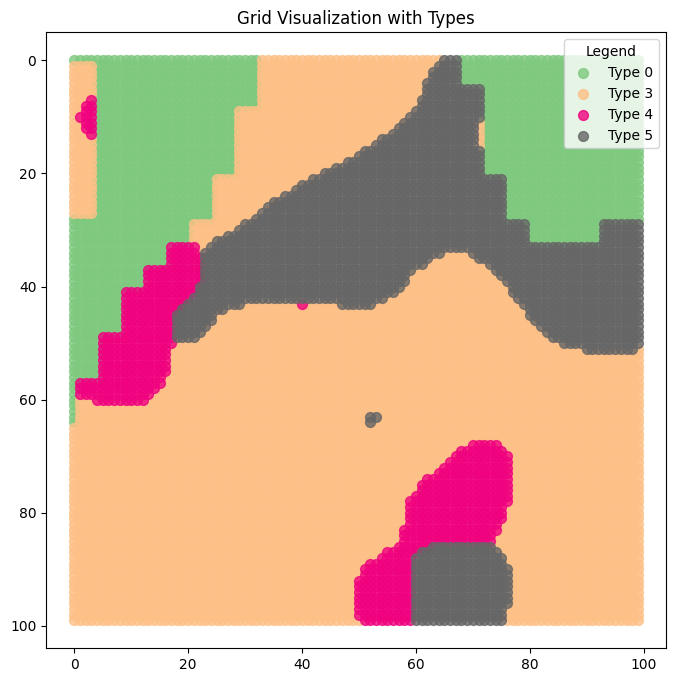

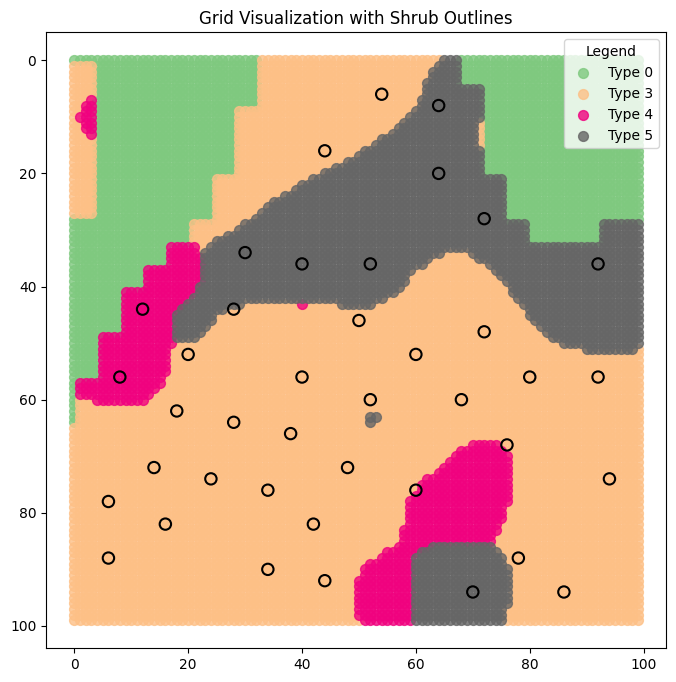

In [22]:
generation, seeds = generate_random_areas_v4(grid_seed=42, distribution_seed=42, number_of_plants=4, visualize=False)
visualize_grid_with_types(generation)
visualize_grid_with_outlines(generation, seeds)

## Things that you should not run on a day to day basis

---

### Function to train new model in case something goes wrongs or zips are lost

IDK why but sending zips of models dun work so if u need to use it, just train below and save the model

YOU DO NOT NEED to run it on a day to day basis!

Loaded model from ./models/23rd.zip
Episode finished after 560 steps
Trees placed at: [(76, 94)]
Shrubs placed at: [(6, 66), (6, 88), (12, 56), (14, 72), (14, 94), (20, 62), (24, 88), (28, 56), (30, 80), (32, 66), (32, 94), (38, 58), (38, 74), (38, 86), (46, 66), (52, 88), (60, 82), (60, 94), (64, 68), (68, 88), (70, 78), (76, 68), (78, 84), (80, 8), (86, 90), (88, 64), (92, 82)]


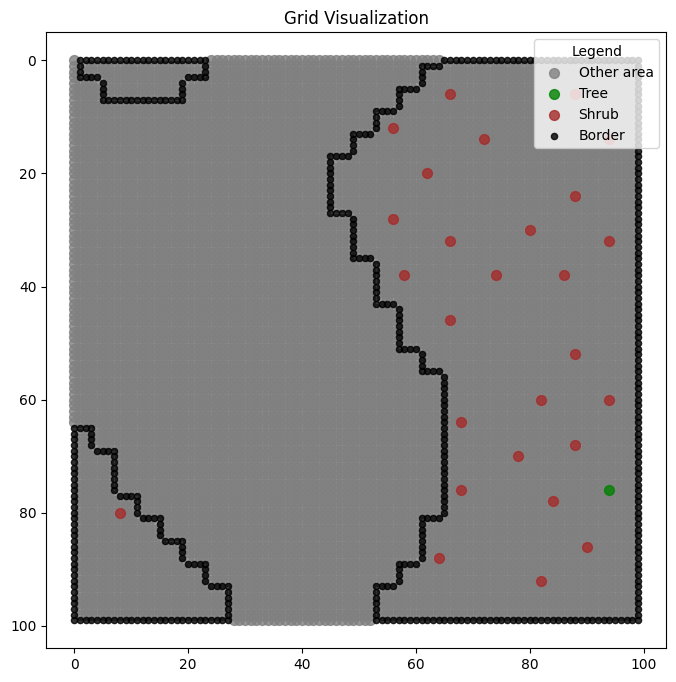

In [11]:
class customSpatialEnv(gym.Env):
    def __init__(self, octave:float, grid_size:tuple=(100,100)):
        """
        Args:
            octave (float): octave value from range [1-2] for perlin noise
            grid_size (tuple): (w, h) of grid, defaults to (100, 100)
        """
        super(customSpatialEnv, self).__init__()

        # Create 100x100 grid
        self.grid_size = grid_size
        self.octave = octave
        self.max_attempts = 100000  # Maximum number of attempts
        self.attempt_counter = 0  # Tracks the number of attempts

        self.grid, self.planting_coordinates, self.distances = self._create_environment()

        # Plants: 1 for Tree, 2 for Shrub, 0 for No plant (added)
        self.plants = np.array([0, 1, 2])  # [No Plant, Tree, Shrub]

        # Action space: Use Box for percentage (horizontal, vertical) and plant type (no object, shrub, tree)
        self.action_space = spaces.Box(low=0.0, high=1.0, shape=(3,), dtype=np.float32)

        # Observation space: Dict containing the grid and distances (both horizontal and vertical)
        self.observation_space = spaces.Dict({
            "horizontal_distance": spaces.Box(low=0, high=1, shape=(1,), dtype=np.float32),  # Horizontal distance (left)
            "vertical_distance": spaces.Box(low=0, high=1, shape=(1,), dtype=np.float32),    # Vertical distance (top)
            "tree_proportion": spaces.Box(low=0, high=1, shape=(1,), dtype=np.float32),  # Proportion of trees
            "shrub_proportion": spaces.Box(low=0, high=1, shape=(1,), dtype=np.float32),  # Proportion of shrubs
            "good_tree_spot": spaces.Box(low=0, high=1, shape=(1,), dtype=np.float32),    # Whether the spot is good for planting a tree
            "border_score": spaces.Box(low=0, high=1, shape=(1,), dtype=np.float32)  
        })

        self.num_trees = 0
        self.num_shrubs = 0
        self.planted_tree_positions = []

    def reset(self, seed=None, options=None):
        """
        Reset the environment to its initial state.
        """
        super().reset(seed=seed)  # Ensure that we call the parent class reset for seeding

        # Recreate the environment (reinitialize grid, planting coordinates, and distances)
        self.grid, self.planting_coordinates, self.distances = self._create_environment()
        self.attempt_counter = 0

        # Start with the first planting coordinate if available, otherwise default to [0, 0] for distances
        if len(self.distances) > 0:
            initial_distances = self.distances[0]
        else:
            initial_distances = [0, 0]  # Handle case where no distances are available

        horizontal_distance, vertical_distance = initial_distances[1], initial_distances[0]

        # Ensure the distances are of type float32
        horizontal_distance = np.array([horizontal_distance], dtype=np.float32)
        vertical_distance = np.array([vertical_distance], dtype=np.float32)

        tree_proportion = np.array([0.0], dtype=np.float32)
        shrub_proportion = np.array([0.0], dtype=np.float32)
        good_tree_spot = np.array([0.0], dtype=np.float32)  # Initial boolean flag (False)
        border_score = np.array([0.0], dtype=np.float32)  # Initial boolean flag (False)

        # Initial observation
        return {
            "horizontal_distance": horizontal_distance,
            "vertical_distance": vertical_distance,
            "tree_proportion": tree_proportion,
            "shrub_proportion": shrub_proportion,
            "good_tree_spot": good_tree_spot,
            "border_score": border_score
        }, {}

    def step(self, action):
        """
        The step function takes a single action, which contains three parts:
        - action[0]: horizontal ratio (0-1).
        - action[1]: vertical ratio (0-1).
        - action[2]: plant type selector (0-1), now including No Plant.
        """

        self.attempt_counter += 1

        # Default value for reward (in case of termination due to exceeding max attempts)
        reward = 0  

        # If the number of attempts exceeds max_attempts, terminate the episode with a penalty
        if self.attempt_counter > self.max_attempts:
            reward = -50  # Apply a significant penalty for exceeding maximum attempts
            terminated = True
            return {
                "horizontal_distance": np.array([0.0], dtype=np.float32),
                "vertical_distance": np.array([0.0], dtype=np.float32),
                "tree_proportion": np.array([0.0], dtype=np.float32),
                "shrub_proportion": np.array([0.0], dtype=np.float32),
                "good_tree_spot": np.array([0.0], dtype=np.float32),
                "border_score": np.array([0.0], dtype=np.float32)
            }, reward, terminated, False, {}

        # Unpack the action
        horizontal_ratio = action[0]
        vertical_ratio = action[1]
        plant_type_selector = action[2]

        # Use the horizontal and vertical ratio to find the nearest planting coordinates
        horizontal_target = horizontal_ratio * self.grid_size[1]  # Scale to grid width
        vertical_target = vertical_ratio * self.grid_size[0]  # Scale to grid height

        # Find the closest coordinate to the generated ratio
        coord_index = np.argmin(np.sum(np.abs(self.planting_coordinates - [vertical_target, horizontal_target]), axis=1))

        # Calculate the difference between the target and the selected plantable coordinates
        selected_coord = self.planting_coordinates[coord_index]
        diff = np.linalg.norm(np.array([vertical_target, horizontal_target]) - np.array(selected_coord))

        # Penalize if the distance is greater than 0.5
        if diff > 20:
            reward = 0  # Apply a penalty for selecting a coordinate that is too far from any plantable spot
            terminated = False
            truncated = False
            return {
                "horizontal_distance": np.array([0.0], dtype=np.float32),
                "vertical_distance": np.array([0.0], dtype=np.float32),
                "tree_proportion": np.array([0.0], dtype=np.float32),
                "shrub_proportion": np.array([0.0], dtype=np.float32),
                "good_tree_spot": np.array([0.0], dtype=np.float32),
                "border_score": np.array([0.0], dtype=np.float32)
            }, reward, terminated, truncated, {}

        # Use the plant type selector to determine the plant type
        if plant_type_selector < 0.33:
            plant_type = 0  # No Plant (new option)
        elif plant_type_selector < 0.66:
            plant_type = 1  # Tree
        else:
            plant_type = 2  # Shrub

        # The rest of the planting logic if a valid spot is selected
        planting_coord = self.planting_coordinates[coord_index]

        if self.grid[planting_coord[0], planting_coord[1]] == 125:  # Plantable spot
            # Update the grid with the selected plant type (1: Tree, 2: Shrub)
            self.grid[planting_coord[0], planting_coord[1]] = self.plants[plant_type]

            if len(self.distances) > 0:  # Ensure there are distances to access
                horizontal_distance, vertical_distance = self.distances[min(coord_index, len(self.distances) - 1)]
            else:
                horizontal_distance, vertical_distance = 0.0, 0.0

            # Remove the planted coordinate from the list to avoid planting again in the same spot
            self.planting_coordinates = np.delete(self.planting_coordinates, coord_index, axis=0)
            self.distances = np.delete(self.distances, coord_index, axis=0)

            ####################################################################################
            ### Shrub Proportion and Tree proportion and reward mechanism
            #  Calculate tree and shrub proportions
            total_plants = self.num_trees + self.num_shrubs
            tree_proportion = self.num_trees / total_plants if total_plants > 0 else 0
            shrub_proportion = self.num_shrubs / total_plants if total_plants > 0 else 0
            balance_reward = 0

            # Update tree and shrub counts
            if self.plants[plant_type] == 1:
                self.num_trees += 1
                self.planted_tree_positions.append(planting_coord)  # Track tree positions
                if tree_proportion > 0.2:
                    balance_reward += 2

            elif self.plants[plant_type] == 2:
                self.num_shrubs += 1
                if shrub_proportion > 0.6:
                    balance_reward += 1

            ####################################################################################
            ### Good Tree Spot and Distance mechanism
            good_tree_spot = 1.0  # Assume the spot is good initially
            if plant_type == 1:  # Only check for trees
                for tree_pos in self.planted_tree_positions:
                    if np.array_equal(tree_pos, planting_coord):
                        continue
                    # Calculate the distance between the planted tree and all other trees
                    dist = np.linalg.norm(np.array(planting_coord) - np.array(tree_pos))
                    if dist < 50:  # If any tree is within 50 units, it's not a good spot
                        good_tree_spot = 0.0
                        break
            distance_reward = 0.5
            # Only apply reward for trees (plant_type == 1)
            if self.plants[plant_type] == 1:
                # Apply a reward based on how far the nearest tree is, capped at 50 units
                if good_tree_spot == 1.0:
                    distance_reward = 1  # Normalize reward (closer to 50 = higher reward)
                else:
                    distance_reward = 0

            ####################################################################################

            ### Border Score Segment

            # Retrieve the distances for the selected planting coordinate
            if len(self.distances) > 0:
                horizontal_distance, vertical_distance = self.distances[min(coord_index, len(self.distances) - 1)]
            else:
                horizontal_distance, vertical_distance = 0.0, 0.0

            border_score = 0
            if (abs(horizontal_distance - 0.5) + abs(vertical_distance - 0.5)) > 0.8:
                border_score = 1

            ####################################################################################

            ### Total reward Segment
            reward = 3 * balance_reward + 2 *distance_reward + border_score
            ####################################################################################

            if plant_type == 0:
            # No planting is done, but a small positive reward could be given to avoid excessive no-action use
                reward = 1

        else:
            # Penalize for trying to plant on a non-plantable spot
            reward = -1
            horizontal_distance, vertical_distance = 0.0, 0.0  # Set to zero if invalid action
            tree_proportion = self.num_trees / (self.num_trees + self.num_shrubs) if (self.num_trees + self.num_shrubs) > 0 else 0
            shrub_proportion = self.num_shrubs / (self.num_trees + self.num_shrubs) if (self.num_trees + self.num_shrubs) > 0 else 0
            good_tree_spot = 0.0

        # Ensure the distances are of type float32
        horizontal_distance = np.array([horizontal_distance], dtype=np.float32)
        vertical_distance = np.array([vertical_distance], dtype=np.float32)
        tree_proportion = np.array([tree_proportion], dtype=np.float32)
        shrub_proportion = np.array([shrub_proportion], dtype=np.float32)
        good_tree_spot = np.array([good_tree_spot], dtype=np.float32)
        border_score = np.array([border_score], dtype=np.float32)

        # Observation: the current state of the environment (grid, distances, and tree/shrub proportions)
        observation = {
            "horizontal_distance": horizontal_distance,
            "vertical_distance": vertical_distance,
            "tree_proportion": tree_proportion,
            "shrub_proportion": shrub_proportion,
            "good_tree_spot": good_tree_spot,
            "border_score": border_score
        }

        # Check if the episode should end (plant all possible spots)
        terminated = len(self.planting_coordinates) == 0

        # Truncated remains False
        truncated = False

        info = {
            'diff': diff  # Add diff to the info dictionary
        }

        return observation, reward, terminated, truncated, info


    def _create_environment(self):
        """
        Function to create a test environment
        Runs perlin noise, dithers
        Ensure that at least 7.5% is plantable
        Filters to ensure minimum 10 grid between all coordinates

        Returns:
            planting_grid (np.ndarray): self.grid_size grid of 0 for unplantable and 1 for plantable
            planting_coord (np.ndarray): (1, num_planting_coord) numpy array
        """ 
        while True:
            noise = PerlinNoise(octaves=self.octave, seed = random.randint(0, 50))
            width, height = self.grid_size

            # Create environment and dither
            perlin_env = np.array([[noise([i/height, j/width]) for j in range(width)] for i in range(height)])
            dithered_perlin_env = self._dither_environment(perlin_env)

            # Check density, more than 7.5% must be plantable
            planting_positions = np.argwhere(dithered_perlin_env == 1)
            planting_density = len(planting_positions) / len(dithered_perlin_env.flatten())

            # If planting density too low, recreate environment with a random grid
            if planting_density > 7.5/100:
                break

        planting_grid, planting_coords  = self._filter_environment(planting_positions)
        boundary = self._draw_and_return_boundary_only(dithered_perlin_env) #just remember to change the input accordingly
        distances, final_grid = self._create_distance_list_grid(planting_grid, boundary, planting_coords)

        return final_grid, planting_coords, distances

    def _dither_environment(self, perlin_env:np.ndarray):
        """
        Function to dither perlin environment using bayer matrix
        
        Args:
            perlin_env (np.ndarray): self.grid_size numpy array with random noise from perlin

        Returns:
            dithered_grid (np.ndarray): self.grid_size grid of 0 for unplantable and 1 for plantable
        """
        # 4x4 Normalised Bayer matrix
        bayer_matrix = np.array([
            [0, 8, 2, 10],
            [12, 4, 14, 6],
            [3, 11, 1, 9],
            [15, 7, 13, 5]
        ]) / 16.0  # Normalisation

        # Dither with Bayer Matrix
        bayer_tile_size = bayer_matrix.shape[0]  # Size of the Bayer matrix (4x4)
        dithered_grid = np.zeros_like(perlin_env)
        width, height = self.grid_size

        # Apply Bayer matrix
        for y in range(height):
            for x in range(width):
                bayer_value = bayer_matrix[y % bayer_tile_size, x % bayer_tile_size]
                dithered_grid[y, x] = 1 if perlin_env[y, x] > bayer_value else 0
        
        return dithered_grid

    def _filter_environment(self, planting_positions:np.ndarray):
        """
        Function to remove close coordinates, ensuring all coordinates are at least 10 apart
        All coordinates within 5 grid of the environment borders are also remove as a buffer effect
        
        Args:
            planting_positions (np.ndarray): numpy array of all plantable coordinates from dithering algorithm

        Returns:
            final_grid (np.ndarray): self.grid_size grid of 0 for unplantable and 1 for plantable
            final_planting_coordinates (np.ndarray): (1, num_planting_coord) numpy array        
        """
        min_distance = 10
        filtered_planting_positions = planting_positions.copy()
        
        # Calculate elucidean distance between coordinates
        distances = cdist(filtered_planting_positions, filtered_planting_positions)

        # Keep a numpy array of all filtered position and assume is true
        keep_array = np.ones(len(filtered_planting_positions), dtype=bool)

        # Check for points that are too close
        for i in range(len(filtered_planting_positions)):
            plant_coordinate = filtered_planting_positions[i]
            # Boundary of 5 pixel to prevent tress on the edge
            if plant_coordinate[0] <= 5 or plant_coordinate[0] >= (self.grid_size[0] -5):
                keep_array[i] = False
            
            if plant_coordinate[1] <= 5 or plant_coordinate[1] >= (self.grid_size[1] -5):
                keep_array[i] = False

            # Only consider points that haven't been removed
            if keep_array[i]:  
                for j in range(i + 1, len(filtered_planting_positions)):
                    if distances[i, j] < min_distance:
                        # Remove the second point if it's too close
                        keep_array[j] = False


        final_planting_coordinates = filtered_planting_positions[keep_array]
        # Final grid (All 0s)
        final_grid = np.zeros(self.grid_size)
        # Update grid with planting position
        for coordinates in final_planting_coordinates:
            final_grid[coordinates[0], coordinates[1]] = 1
        return final_grid, final_planting_coordinates

    def _draw_and_return_boundary_only(self, input_grid, threshold_value=128, contour_value=255, dilation_iterations=3):
        '''
        Draws a precise boundary around all yellow regions in the unfiltered grid and returns an array with only the boundary values.
        
        Parameters:
        - threshold_value: int -- the threshold value to segment the yellow area (default: 128).
        - contour_value: int -- the value to set for the boundary pixels in the array (default: 255 for white).
        - dilation_iterations: int -- number of iterations for dilating the image to smooth out the areas (default: 3).
        
        Returns:
        - boundary_array: np.array -- the NumPy array containing only the boundary values.
        '''
        
        # Access the unfiltered grid from the environment
        unfiltered_grid = input_grid
        # Normalize the array to the range 0-255 (assuming it's a float array in range 0-1)
        normalized_image = (unfiltered_grid * 255).astype(np.uint8)

        # Apply a threshold to isolate the yellow area
        _, thresh = cv2.threshold(normalized_image, threshold_value, 255, cv2.THRESH_BINARY)

        # Optionally dilate the thresholded image to fill in gaps in the contours
        if dilation_iterations > 0:
            kernel = np.ones((3, 3), np.uint8)
            thresh = cv2.dilate(thresh, kernel, iterations=dilation_iterations)

        # Find contours on the thresholded image (we only want external contours)
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Create an empty array (same shape as normalized_image) to store only the boundary
        boundary_array = np.zeros_like(normalized_image)

        # Draw the contours on the boundary array (without the original regions, only the contours)
        cv2.drawContours(boundary_array, contours, -1, contour_value, thickness=1)

        # Optionally show the boundary array for visualization (you can remove this for efficiency in the environment)
        # plt.imshow(boundary_array, cmap='gray')
        # plt.show()

        # Return the boundary array for further use within the environment
        return boundary_array
    
    def _set_array_borders(self, arr, border_thickness = 5, value = 0):
        '''
        Sets the borders of the class's array to a specified value.
        
        Parameters:
        - border_thickness: int -- the thickness of the border to modify.
        - value: int or float -- the value to set for the borders.
        
        Modifies:
        - self.grid or any other attribute that stores the grid.
        '''
        
        # Assuming the class has a grid or unfiltered grid attribute, modify the array in place.

        # Set top and bottom borders
        arr[:border_thickness, :] = value  # Top border
        arr[-border_thickness:, :] = value  # Bottom border
        
        # Set left and right borders
        arr[:, :border_thickness] = value  # Left border
        arr[:, -border_thickness:] = value  # Right border
        
        # You can also return the modified grid if necessary
        return arr
    
    def _create_distance_list_grid(self, grid, boundary, coordinates):
        '''
        Create the list of distances of each node from the bouyndary values
        
        Parameters:
        - grid: int -- the thickness of the border to modify.
        - boundary: int or float -- the value to set for the borders.
        
        Modifies:
        - self.grid or any other attribute that stores the grid.
        '''

        directions = [
            (-1, 0),  #U
            (1, 0),  #D
            (0, -1), #L
            (0, 1)   #R
        ]

        distances = []
        testing_copy = np.copy(boundary)

        
        for coords in coordinates:
            if grid[coords[0], coords[1]] != 1:
                print("Not Seed position")
                continue

            starting_x, starting_y = coords[1], coords[0]
            testing_copy[coords[0], coords[1]] = 125

            temp_distances = []
            for x, y in directions:
                step = 0
                current_x, current_y = starting_x, starting_y
                while 0 <= current_x < self.grid_size[0] and 0 <= current_y < self.grid_size[1]:
                    step += 1
                    current_x += x
                    current_y += y
                    if boundary[current_x, current_y] == 255:
                        temp_distances.append(step)
                        break
                    if current_x == 0 or current_x == 99 or current_y == 0 or current_y == 99:
                        temp_distances.append(step)
                        break

            horizontal_distance_L = temp_distances[2]/(temp_distances[2] + temp_distances[3])
            horizontal_distance_R = temp_distances[3]/(temp_distances[2] + temp_distances[3])

            vertical_distance_D = temp_distances[1]/(temp_distances[0] + temp_distances[1])
            vertical_distance_U = temp_distances[0]/(temp_distances[0] + temp_distances[1])
            distances.append([vertical_distance_U, horizontal_distance_L])
        return distances, testing_copy

    
    
import matplotlib.patches as mpatches
    
def load_model(env):
    global model
    model = PPO("MultiInputPolicy", env, verbose=1, n_steps=2048, gamma=0.99, learning_rate=0.0003, ent_coef=0.05)
    return model

# Train the model without saving automatically
def train_model(env):
    global model
    model.learn(total_timesteps=100000)
    return model

# Function to render one episode and test the model
def render_episode(env, model):
    obs, _ = env.reset()
    step = 0
    while True:
        action, _states = model.predict(obs, deterministic=False)
        action, _states = model.predict(obs, deterministic=False)

        # Add some noise to the action to encourage exploration
        noise = np.random.normal(0, 0.1, size=action.shape)  # Adjust noise level as needed
        action += noise
        action = np.clip(action, 0, 1)
        obs, reward, terminated, truncated, info = env.step(action)
        step += 1
        diff = info.get('diff', None)  # Get the diff from the info dictionary
        # print(f"Step {step}: Reward = {reward}, Action = {action}, Diff = {diff}")

        if terminated or truncated:
            print(f"Episode finished after {step} steps")
            break

    return model

def load_pretrained_model(model_path):
    """
    Load a pretrained PPO model from a specified path.
    """
    if not os.path.exists(model_path):
        raise ValueError(f"Model path {model_path} does not exist.")
    
    model = PPO.load(model_path)
    print(f"Loaded model from {model_path}")
    return model


def generate_new_placement(env, model):
    """
    Generate a new grid and use the model to place trees, shrubs, or no plant until all plantable spots are used.
    """
    obs, _ = env.reset()
    step = 0

    while True:
        action, _states = model.predict(obs, deterministic=False)
        noise = np.random.normal(0, 0.05, size=action.shape)
        randomized_action = np.clip(action + noise, 0, 1)
        obs, reward, terminated, truncated, info = env.step(randomized_action)
        
        step += 1

        if terminated or truncated:
            print(f"Episode finished after {step} steps")
            break

    return env.grid  # Only return the grid


def extract_tree_shrub_placements(grid):
    """
    Extracts the tree and shrub placements from the final grid.
    
    Args:
        grid (np.ndarray): The final grid after placement.
    
    Returns:
        trees (list of tuple): List of coordinates of tree placements.
        shrubs (list of tuple): List of coordinates of shrub placements.
    """
    trees = list(zip(*np.where(grid == 1)))
    shrubs = list(zip(*np.where(grid == 2)))
    return trees, shrubs


# Main function to load model and generate new placement
def createGrid(model_path):
    env = customSpatialEnv(octave=1.5, grid_size=(100, 100))
    model = load_pretrained_model(model_path)
    final_grid = generate_new_placement(env, model)
    return final_grid


# Visualization (optional, for debugging)
def visualize_grid_with_circles(grid):
    plt.figure(figsize=(8, 8))
    marker_styles = {
        0: {'color': 'gray', 'label': 'Other area', 'size': 50},
        125: {'color': 'yellow', 'label': 'Plantable', 'size': 50},
        1: {'color': 'green', 'label': 'Tree', 'size': 50},
        2: {'color': 'brown', 'label': 'Shrub', 'size': 50},
        3: {'color': 'blue', 'label': 'No Plant', 'size': 50},
        255: {'color': 'black', 'label': 'Border', 'size': 20},
    }

    for value, style in marker_styles.items():
        indices = np.argwhere(grid == value)
        if len(indices) > 0:
            plt.scatter(indices[:, 1], indices[:, 0], color=style['color'], label=style['label'], s=style['size'], alpha=0.8)

    plt.gca().invert_yaxis()
    plt.legend(title="Legend", loc='upper right')
    plt.title("Grid Visualization")
    plt.grid(False)
    plt.show()


if __name__ == "__main__":
    # Specify the path to the pretrained model directory
    model_path = "./models/23rd.zip"
    final_grid = createGrid(model_path)
    trees, shrubs = extract_tree_shrub_placements(final_grid)
    print("Trees placed at:", trees)
    print("Shrubs placed at:", shrubs)

    # Optional visualization
    visualize_grid_with_circles(final_grid)


# Experimental Zone
Cause I am too lazy to go copy paste this stuff in another file

---

## Tier 2 Experimentaiton

### Creating the new heatmap based on the noise function together with input from the border

Loaded model from ./models/23rd.zip
Episode finished after 494 steps


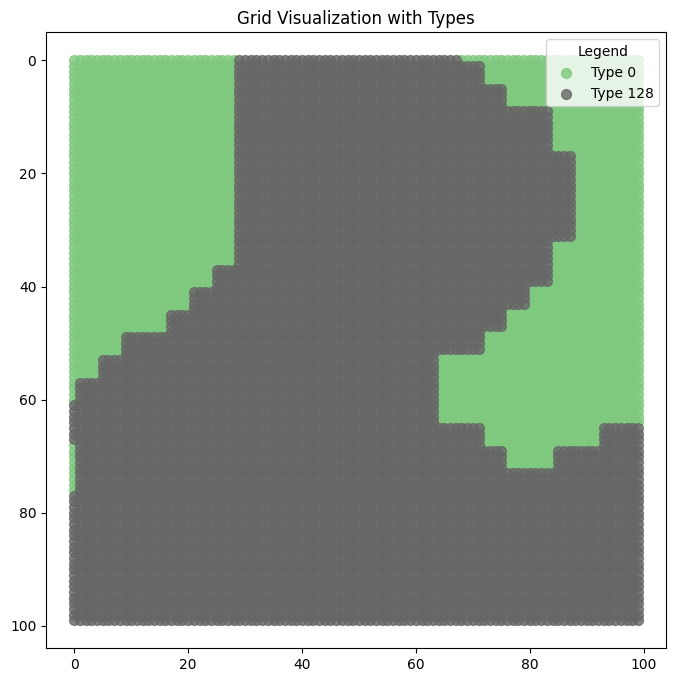

In [95]:
model_path = "./models/23rd.zip"
grid= createGrid(model_path)
grid = shade_inside_border(grid)
visualize_grid_with_types(grid)

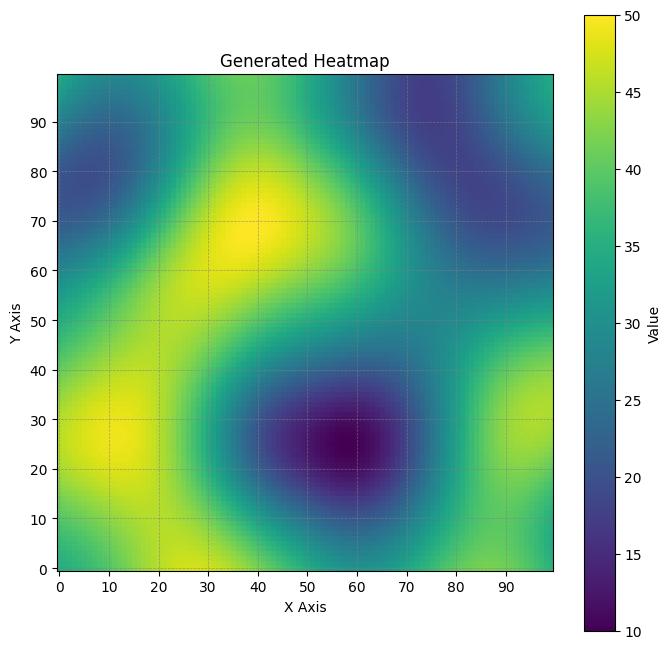

In [97]:
heatmap = generate_heatmap(grid_size=(100, 100), octaves=2, value_range=(10, 50), invert=True)
visualize_heatmap(heatmap)

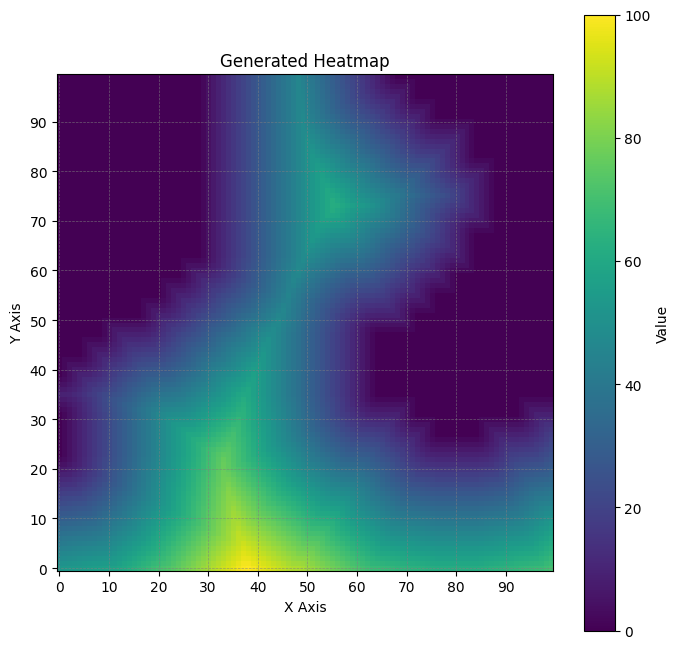

In [100]:
def calculate_distance_to_border(grid, invert=False):
    """
    Calculate and normalize the distance of each pixel to the nearest border of the area with type 128.
    Optionally invert the distances, so points closest to the border are the highest value.

    Args:
        grid (np.ndarray): 2D array where 128 represents the target area.
        invert (bool): If True, inverts the distances so points closest to the border are the highest.

    Returns:
        np.ndarray: A 2D array of the same shape as the input, containing normalized distances.
    """
    # Create a binary mask where type 128 is 1 and everything else is 0
    binary_mask = (grid == 128).astype(np.uint8)

    # Apply distance transform
    distance_to_border = cv2.distanceTransform(binary_mask, distanceType=cv2.DIST_L2, maskSize=5)

    # Normalize the distances to ensure the innermost area is 100
    max_distance = np.max(distance_to_border)
    if max_distance > 0:
        normalized_distance_map = (distance_to_border / max_distance) * 100  # Scale to range [0, 100]
    else:
        normalized_distance_map = distance_to_border  # If no distance, return the original map

    # Optionally invert the distances
    if invert:
        normalized_distance_map = 100 - normalized_distance_map

    # Flip the distance map vertically
    flipped_distance_map = np.flipud(normalized_distance_map)

    return flipped_distance_map


# Example usage
normalized_distance_map = calculate_distance_to_border(grid, invert=False)  # Toggle invert as needed

visualize_heatmap(normalized_distance_map)


In [101]:
def visualize_heatmap(grid, title="Heatmap", colorbar_label="Value", cmap="plasma"):
    """
    Visualize a 2D grid as a heatmap with a vibrant colormap and enhanced styling.

    Args:
        grid (np.ndarray): The 2D array representing the grid.
        title (str): The title of the plot.
        colorbar_label (str): The label for the colorbar.
        cmap (str): The colormap to use for visualization.
    """
    plt.figure(figsize=(8, 8))
    im = plt.imshow(grid, cmap=cmap, origin="lower")
    cbar = plt.colorbar(im)
    cbar.set_label(colorbar_label)
    plt.title(title)
    plt.xlabel("X Axis")
    plt.ylabel("Y Axis")

    # Add explicit axis ticks
    plt.xticks(np.arange(0, grid.shape[1], step=10))  # Adjust step size as needed
    plt.yticks(np.arange(0, grid.shape[0], step=10))  # Adjust step size as needed

    plt.grid(color='white', linestyle='--', linewidth=0.5, alpha=0.5)  # Optional grid lines
    plt.show()

# Example usage:
# Assuming `heatmap` is your grid
# visualize_heatmap(summed_grid, title="Generated Heatmap", colorbar_label="Heatmap Value")


Ensuring that the 2 functions have equal weightage
- Noise function: Generates random noise on a range
- Permeter function: Heatmap calculated from distance either away or close to border|

In [102]:
def generate_heatmap(distribution_seed=None, grid_size=(100, 100), octaves=4, value_range=(10, 50), invert=False):
    """
    Generate a random heatmap using Perlin noise.

    Args:
        distribution_seed (int or None): Seed for reproducibility of the grid generation.
        grid_size (tuple): The size of the heatmap (width, height).
        octaves (int): Number of octaves for the Perlin noise (controls the detail level).
        value_range (tuple): The range of values for the heatmap (min, max).
        invert (bool): Whether to invert the values in the heatmap.
    
    Returns:
        np.ndarray: A 2D array representing the heatmap.
    """
    if distribution_seed is not None:
        random.seed(distribution_seed)
        np.random.seed(distribution_seed)

    # Initialize Perlin noise generator
    noise = PerlinNoise(octaves=octaves, seed=distribution_seed)

    # Generate noise values for the grid
    width, height = grid_size
    heatmap = np.array([[noise([i / height, j / width]) for j in range(width)] for i in range(height)])

    # Normalize the noise values to the desired range
    min_val, max_val = value_range
    heatmap = (heatmap - np.min(heatmap)) / (np.max(heatmap) - np.min(heatmap))  # Normalize to 0-1
    
    # Invert the heatmap if required
    if invert:
        heatmap = 1 - heatmap

    heatmap = heatmap * (max_val - min_val) + min_val  # Scale to the desired range

    return heatmap

def visualize_heatmap(grid, title="Generated Heatmap", colorbar_label="Value", cmap="viridis"):
    """
    Visualize a 2D grid with explicit axis labels and ticks.

    Args:
        grid (np.ndarray): The 2D array representing the grid.
        title (str): The title of the plot.
        colorbar_label (str): The label for the colorbar.
        cmap (str): The colormap to use for visualization.
    """
    plt.figure(figsize=(8, 8))
    im = plt.imshow(grid, cmap=cmap, origin="lower")
    cbar = plt.colorbar(im)
    cbar.set_label(colorbar_label)
    plt.title(title)
    plt.xlabel("X Axis")
    plt.ylabel("Y Axis")

    # Add explicit axis ticks
    plt.xticks(np.arange(0, grid.shape[1], step=10))  # Adjust step size as needed
    plt.yticks(np.arange(0, grid.shape[0], step=10))  # Adjust step size as needed

    plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)  # Optional grid lines
    plt.show()

# Generate and visualize the heatmap
# heatmap = generate_heatmap(grid_size=(100, 100), octaves=2, value_range=(10, 50), invert=True)
# # visualize_heatmap(heatmap)

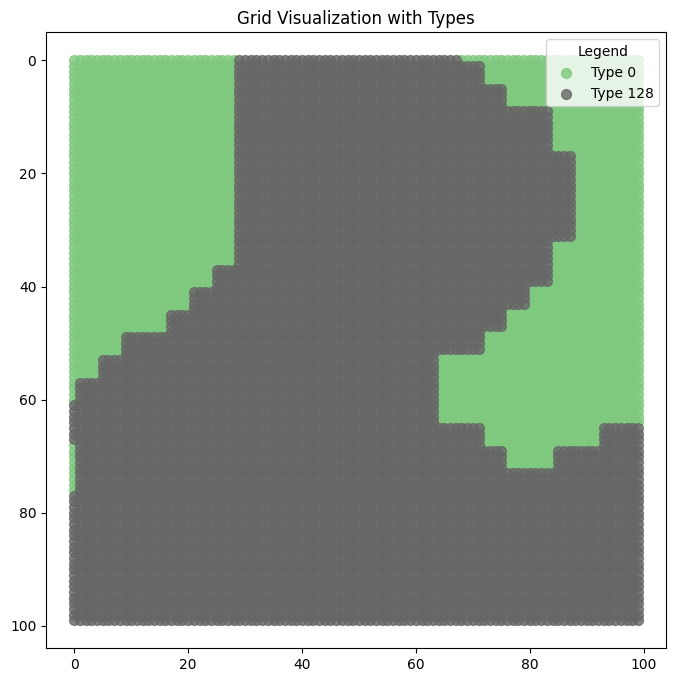

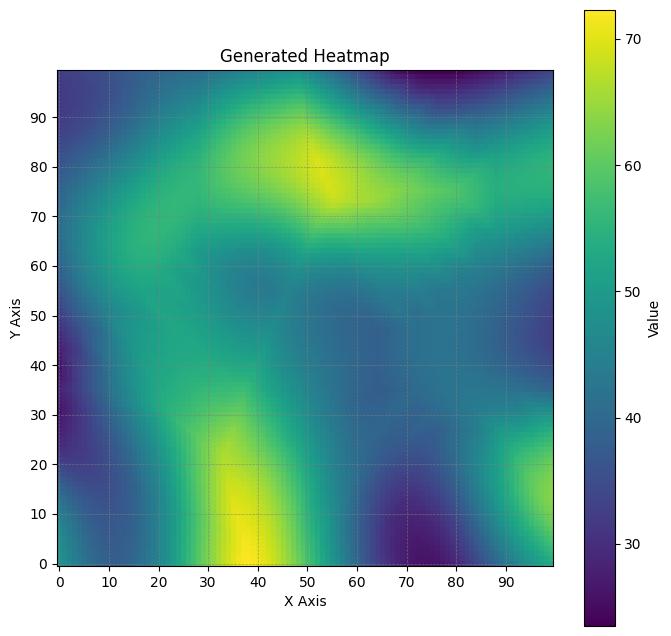

In [ ]:
import numpy as np

def generate_combined_heatmap(grid, grid_size = (100,100), distribution_seed=None, orderliness=0.3, lower_noise=10, upper_noise=80, theme=None):
    """
    Generate a combined heatmap by summing two grids element-wise, weighted by the `orderliness` parameter.

    Args:
        grid (np.ndarray): The primary grid (2D array) used to calculate the perimeter map.
        distribution_seed (int, optional): Seed for reproducibility of random noise generation.
        orderliness (float): The proportion of weight for the perimeter map (0 <= orderliness <= 1).
        theme (str, optional): Theme to determine if the perimeter map should be inverted.

    Returns:
        np.ndarray: A 2D array containing the weighted sum of the two grids.
    """
    # Ensure orderliness is within valid range
    if not (0 <= orderliness <= 1):
        raise ValueError("Orderliness must be between 0 and 1.")

    # Determine inversion based on theme
    inversion = False
    if theme == "Road":
        inversion = True

    # Generate noise and perimeter maps
    noise_map = generate_heatmap(grid_size=grid_size, octaves=2, distribution_seed=distribution_seed,value_range=(lower_noise, upper_noise), invert=False)
    visualize_heatmap(noise_map)
    perimeter_map = calculate_distance_to_border(grid, invert=inversion)
    visualize_heatmap(perimeter_map)

    # Ensure the shapes match
    if noise_map.shape != perimeter_map.shape:
        raise ValueError("The grids must have the same shape to perform element-wise addition.")

    # Calculate weighted sum
    combined_heatmap = (orderliness * perimeter_map) + ((1 - orderliness) * noise_map)

    return combined_heatmap

# Example usage:
# Assuming `grid1` and `grid2` are your heatmap and normalized distance map arrays
summed_grid = generate_combined_heatmap(grid, distribution_seed=42)
visualize_grid_with_types(grid)
visualize_heatmap(summed_grid)

In [111]:
def produce_data_v4(model_path = "./models/23rd.zip", grid_seed=None, distribution_seed = None, number_of_plants=4, percentage_shurbs=0.8, lower_noise = 10, upper_noise =80, visualise=False):
    ##
    grid = createGrid(model_path, grid_seed)
    grid_size = grid.shape
    trees, shrubs = extract_tree_shrub_placements(grid)

    random_points, seeds = choose_starter_slots(grid, shrubs, distribution_seed=distribution_seed, number_of_types=number_of_plants, percentage_of_starters=percentage_shurbs)
    combined_heatmap = generate_combined_heatmap(grid, grid_size=grid_size, distribution_seed=distribution_seed, orderliness=0.3, lower_noise=lower_noise, upper_noise=upper_noise, theme=None)
    plantable_grid = shade_inside_border(grid)
    # To be replaced with a proper tree radius retrival system once PoC is done
    distance_threshold = 25
    nearTree_grid = label_near_trees(grid, tree_value=1, distance_threshold=distance_threshold)

    influence_grids = {}
    for index in range(number_of_plants):
        plant_index_influence_grid = generate_influence_grid_plant_type(combined_heatmap, seeds[3 + index])
        influence_grids[index + 3] = plant_index_influence_grid
    
    shaded_dict = {plant_type: (plant_type % 2 == 0) for plant_type in range(3, 3 + number_of_plants)}


    ## Visualisation
    if visualise:
        print(seeds)
        visualize_grid_with_types(grid)
        visualize_grid_with_types(random_points)
        visualize_heatmap(combined_heatmap)
        visualize_binary_grid(plantable_grid)
        visualize_binary_grid(nearTree_grid)
        for index in range(number_of_plants):
            visualize_influence_grid(influence_grids[index + 3])
    return plantable_grid, nearTree_grid, influence_grids, shaded_dict, seeds

In [112]:
def generate_random_areas_v5(grid_seed=None, distribution_seed= None, number_of_plants=4, percentage_shurbs=0.8, lower_noise = 30, upper_noise =50, threshold=0.05, visualize=False):
    """
    Generate a random distribution of plant types within the plantable area, based on influence grids and shading.
    If the influence values are very close (difference < threshold), decide randomly.

    Args:
        number_of_plants (int): The number of plant types to consider (e.g., 3, 4, 5).
        visualize (bool): Whether to visualize the grids.
        threshold (float): The maximum difference between influences to trigger random selection.

    Returns:
        np.ndarray: A grid with the randomized types assigned to plantable areas.
    """
    # Generate required grids and data
    plantable_area, nearTree_grid, influence_grids, shaded_dict, seeds = produce_data_v4(
        grid_seed= grid_seed, distribution_seed=distribution_seed, number_of_plants=number_of_plants, percentage_shurbs=percentage_shurbs, lower_noise=lower_noise, upper_noise=upper_noise, visualise=visualize
    )

    # Create a copy of the plantable area grid for random assignment
    plantable_area_copy = np.copy(plantable_area)

    # Iterate through each cell in the plantable area
    for i in range(plantable_area.shape[0]):
        for j in range(plantable_area.shape[1]):
            if plantable_area[i, j] == 128:  # If the spot is plantable
                # Calculate influence values from each type at this spot
                influences = [
                    (influence_grids[plant_type][i, j], plant_type)
                    for plant_type in range(3, 3 + number_of_plants)
                ]

                # Check if the area is shaded
                is_shaded = nearTree_grid[i, j] == 1

                # Adjust influence for shaded areas
                for idx, (influence, plant_type) in enumerate(influences):
                    if is_shaded and shaded_dict.get(plant_type, False):
                        influences[idx] = (influence + 0.1 * influence, plant_type)

                # Sort influence values with their corresponding types
                influences.sort(reverse=True, key=lambda x: x[0])  # Sort by influence value

                # Decide based on the difference between top two influences
                if abs(influences[0][0] - influences[1][0]) < threshold:
                    # Randomly select between the top two types
                    random_type = random.choice([influences[0][1], influences[1][1]])
                else:
                    # Select the type with the highest influence
                    random_type = influences[0][1]

                # Assign the type to the plantable area copy
                plantable_area_copy[i, j] = random_type
            
        
    return plantable_area_copy, seeds

Loaded model from ./models/23rd.zip
Episode finished after 696 steps


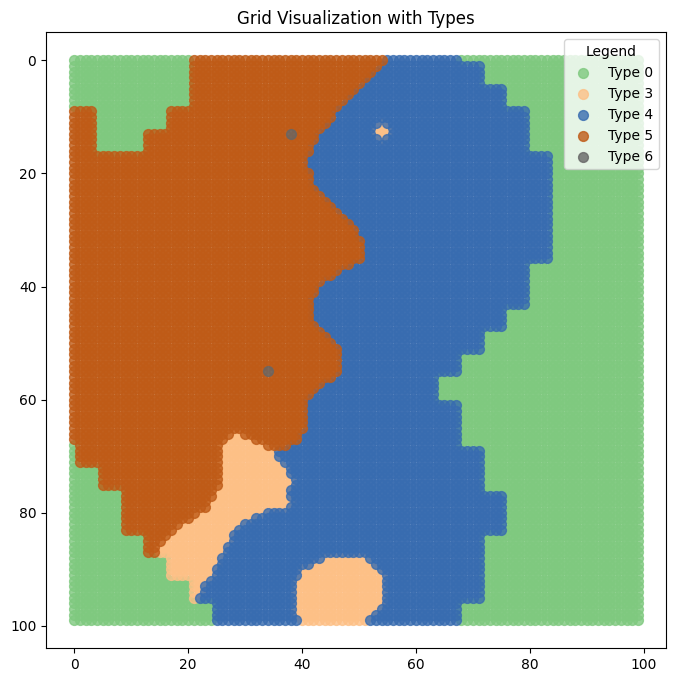

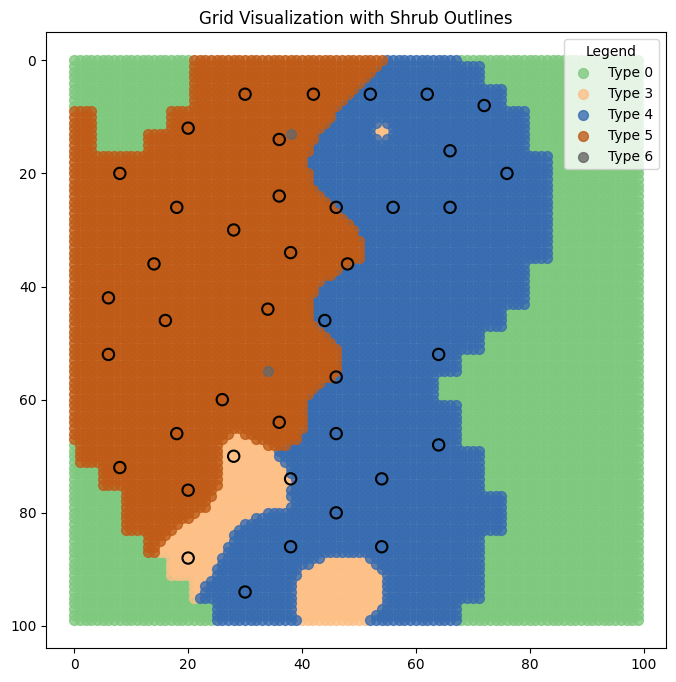

In [120]:
generation, seeds = generate_random_areas_v5(grid_seed=0, distribution_seed=None, number_of_plants=4, visualize=False)
visualize_grid_with_types(generation)
visualize_grid_with_outlines(generation, seeds)